In [37]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sys
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
import tensorflow.python.keras
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization,SpatialDropout1D,Bidirectional, Embedding, LSTM
from tensorflow.python.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
import re

np.set_printoptions(threshold=sys.maxsize)

pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)

# GPU support
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [28]:
file = "dataset_file/file.txt"

splitted_line = []

with open(file) as f:
    for line in f.readlines():
        # print(line)
        if  int(line[0]) in [1,2,3,4]:
            splitted_line.append([line[0], line[2:]])


print(splitted_line.pop(0))



['1', 'champion products ch approves stock split champion products inc said its board of directors approved a two for one stock split of its common shares for shareholders of record as of april the company also said its board voted to recommend to shareholders at the annual meeting april an increase in the authorized capital stock from five mln to mln shares reuter \n']


In [29]:
dataset = pd.DataFrame(list(splitted_line), columns=["labels", "text"])

In [30]:
dataset.head()

,labels,text
0,2,computer terminal systems cpml completes sale ...
1,1,cobanco inc cbco year net shr cts vs dlrs net ...
2,1,am international inc am nd qtr jan oper shr lo...
3,1,brown forman inc bfd th qtr net shr one dlr vs...
4,1,dean foods df sees strong th qtr earnings dean...


In [31]:
X = dataset["text"].values
y = dataset["labels"].values

y = to_categorical(y)

In [32]:
tokenizer = Tokenizer(num_words= None)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

# # Example
# print(X[0])
# print(sequences[0])

computer terminal systems cpml completes sale computer terminal systems inc said it has completed the sale of shares of its common stock and warrants to acquire an additional one mln shares to sedio n v of lugano switzerland for dlrs the company said the warrants are exercisable for five years at a purchase price of dlrs per share computer terminal said sedio also has the right to buy additional shares and increase its total holdings up to pct of the computer terminal s outstanding common stock under certain circumstances involving change of control at the company the company said if the conditions occur the warrants would be exercisable at a price equal to pct of its common stock s market price at the time not to exceed dlrs per share computer terminal also said it sold the technolgy rights to its dot matrix impact technology including any future improvements to woodco inc of houston tex for dlrs but it said it would continue to be the exclusive worldwide licensee of the technology fo

In [33]:
X_encoded = pad_sequences(sequences, maxlen=80, padding='post')

print(X_encoded[0])

[  356  2036    62     9    12   247     1 10762   385     3    18  1214
  6587   739   433   305   190   357  2302     3  8061    23     2  1278
  8062    13    10    63    12     9    12    47   348     3    33     1
  2973  1012  3406     2     1   433    13  8061     1    21     9     1
  1215    76   253     2    18  1360   224     8    47   667    96   159
   646   271     8  2037   632  1427   356  2036   625   356  2974  5636
  2639 10763     8  3986  4936     8  3664    15]


In [42]:
# Split into training set and test set. Use a test size = 3000 and a random state = 0
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.10, random_state=0,stratify = y)

In [45]:
X_train_one, X_train_two, y_train_one, y_test_two = train_test_split(X_train, y_train, test_size=0.50, random_state=44,stratify = y_train)

In [47]:
# Design a LSTM neural network and use an embedding layer.
vocabulary_size = X_train_one.max()

model = Sequential()
model.add(Embedding(vocabulary_size+1, 150, input_length=80))
model.add(SpatialDropout1D(0.3))
# model.add(LSTM(500,return_sequences=True, dropout=0.2, recurrent_dropout=0.15))
model.add(LSTM(100, dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(500, activation='relu'))
model.add(Dense(5, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



In [22]:
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
import time
from datetime import datetime, date
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, min_delta=0.001, patience=5, restore_best_weights=True)

END = f'{datetime.timestamp(datetime.now())}_{date.today().strftime("%b-%d-%Y")}'

NAME = 'logs/text_classification_model{}'.format(int(time.time()))
tensorboard = TensorBoard(log_dir=f'{NAME}_{END}')

checkpoint_filepath = f'models/text_classification_{END}.h5'
checkpointer = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor='val_accuracy',mode='max',save_best_only=True)

callback_list = [tensorboard, checkpointer, es]

In [50]:
history = model.fit(X_train_one, y_train_one, epochs=100,verbose=1,batch_size=128, validation_split=0.2, callbacks=callback_list)

Epoch 1/100
14/14 [==============================] - 17s 1s/step - loss: 1.0595 - accuracy: 0.5994 - val_loss: 0.8919 - val_accuracy: 0.6713
Epoch 2/100
14/14 [==============================] - 18s 1s/step - loss: 0.8278 - accuracy: 0.6174 - val_loss: 0.8184 - val_accuracy: 0.6736
Epoch 3/100
14/14 [==============================] - 17s 1s/step - loss: 0.7458 - accuracy: 0.7003 - val_loss: 0.7568 - val_accuracy: 0.6644
Epoch 4/100
14/14 [==============================] - 17s 1s/step - loss: 0.6283 - accuracy: 0.7774 - val_loss: 0.6674 - val_accuracy: 0.7407
Epoch 5/100
14/14 [==============================] - 17s 1s/step - loss: 0.3793 - accuracy: 0.8754 - val_loss: 0.3328 - val_accuracy: 0.8958
Epoch 6/100
14/14 [==============================] - 16s 1s/step - loss: 0.2242 - accuracy: 0.9328 - val_loss: 0.4232 - val_accuracy: 0.8750
Epoch 7/100
14/14 [==============================] - 16s 1s/step - loss: 0.1482 - accuracy: 0.9536 - val_loss: 0.4006 - val_accuracy: 0.9097
Epoch 8/100
1

In [54]:
history = model.fit(X_train_two, y_test_two, epochs=100,verbose=1,batch_size=128, validation_split=0.2, callbacks=callback_list)

Epoch 1/100
14/14 [==============================] - 17s 1s/step - loss: 0.3071 - accuracy: 0.9107 - val_loss: 0.3540 - val_accuracy: 0.9051
Epoch 2/100
14/14 [==============================] - 17s 1s/step - loss: 0.1644 - accuracy: 0.9478 - val_loss: 0.2471 - val_accuracy: 0.9120
Epoch 3/100
14/14 [==============================] - 17s 1s/step - loss: 0.1028 - accuracy: 0.9693 - val_loss: 0.4014 - val_accuracy: 0.9028
Epoch 4/100
14/14 [==============================] - 18s 1s/step - loss: 0.0962 - accuracy: 0.9693 - val_loss: 0.3445 - val_accuracy: 0.9005
Epoch 5/100
14/14 [==============================] - 17s 1s/step - loss: 0.0790 - accuracy: 0.9757 - val_loss: 0.3086 - val_accuracy: 0.9074
Epoch 6/100
14/14 [==============================] - 16s 1s/step - loss: 0.0559 - accuracy: 0.9826 - val_loss: 0.2797 - val_accuracy: 0.9167
Epoch 7/100
14/14 [==============================] - 15s 1s/step - loss: 0.0452 - accuracy: 0.9809 - val_loss: 0.2703 - val_accuracy: 0.9074
Restoring mod

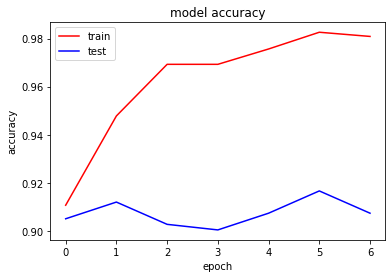

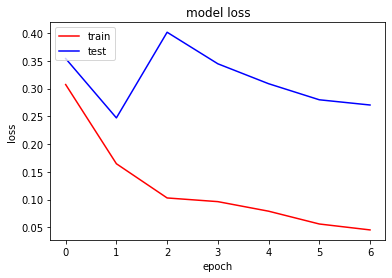

In [55]:
# Plot history

# Accuray 
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'b')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Loss 
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'b')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [57]:
# Validate model on training set
rounded_labels=np.argmax(y_test, axis=1)

y_pred = np.argmax(model.predict(X_test),axis=-1)

print(classification_report(rounded_labels, y_pred))

cf = confusion_matrix(rounded_labels, y_pred)

print(cf)
print(accuracy_score(rounded_labels, y_pred) * 100) 

              precision    recall  f1-score   support

           1       0.99      0.94      0.97       284
           2       0.88      0.98      0.93       160
           3       0.71      0.80      0.75        25
           4       0.50      0.09      0.15        11

    accuracy                           0.93       480
   macro avg       0.77      0.70      0.70       480
weighted avg       0.93      0.93      0.92       480

[[268  16   0   0]
 [  3 157   0   0]
 [  0   4  20   1]
 [  0   2   8   1]]
92.91666666666667


In [122]:
file = "dataset_file/fabricated_file.txt"

splitted_line = []
from random import choice, randint

with open(file) as f:
    for line in f.readlines():
        # print(line)
        splitted_line.append([line[0], line[2:]])



In [123]:

print(len(splitted_line[0]))

brand_file = "dataset_file/brand_file.txt"
with open(brand_file) as f: 
    brand_list = f.read().splitlines()
    # for brand in f.readline():
    #     brand_list.append(str(brand))

2


In [124]:

data_list = []
for x in range(len(splitted_line)): 
    sentence = splitted_line[x]
    brand_index = brand_list.index(choice(brand_list))
    splitted_sentence = sentence[1].split(" ")
    random_index = randint(0, len(splitted_sentence)-1)
    splitted_sentence[random_index] = brand_list[brand_index]
    # print(f"Difference {len(splitted_sentence) - lenght_before }")
    combined_sentence = " ".join(splitted_sentence)
    sentence.append(combined_sentence)
    sentence.append(brand_index)
    sentence.append(brand_list[brand_index])
    # print(len(sentence))
    data_list.append(sentence)

print("Done")
print(data_list[randint(0, len(splitted_line)-1)])

Done
['1', 'citicorp cci sees doubling in retail bank net citicorp expects net income in its individual banking sector to top one billion dlrs by compared with mln dlrs in said richard braddock head of citicorp s individual banking division we can double our earnings over the next five to seven years he told a banking analysts meeting adding that this forecast may be on the conservative side he said that bank card operations and the new york branch system would continue to turn in hefty profits but also picked out other developing areas such as u s mortgage and international consumer as major potential earners braddock and his sector heads made the following more specific predictions cost of funds and net credit loss levels in the u s bankcard unit will taper off in coming years from s relatively inflated levels customer net revenue in the mortgage banking area will rise to mln dlrs in from mln in the international consumer business will show pct compound annual growth in earnings betw

In [125]:
for item in data_list[randint(0, len(splitted_line)-1)]:
    print(item)

3
yeutter says u s japan trade difficulties remain u s trade representative clayton yeutter said he was unsure whether some of the trade issues straining u s japanese relations would be resolved before the two countries open trade talks in late april we are having high level discussions on them the issues within the united states the relationship on some of those is very strained between us japan at the moment and we need to relieve those strains at the earliest possible date he said i am not sure we can wait until late april he added yeutter is in new zealand for a two day informal meeting of trade ministers who are reviewing the uruguay round of the general agreement on trade and tariffs gatt he said he will meet the japanese delegation over the next few days but declined to discuss methods of relieving the strain between the two countries yeutter said earlier the three most contentious trade issues were semiconductors japanese government unwillingness to allow public entities to buy

In [126]:
dataset = pd.DataFrame(list(data_list), columns=["labels", "native_text", "branded_text","brand_index", "brand"])

In [147]:


y = dataset["brand_index"].values
X = dataset["branded_text"].values

y = to_categorical(y)

In [148]:
dataset.head()

,labels,native_text,branded_text,brand_index,brand
0,1,champion products ch approves stock split cham...,champion products ch approves stock split cham...,5,Waterman
1,2,computer terminal systems cpml completes sale ...,computer terminal systems cpml completes sale ...,8,Wrigley
2,1,cobanco inc cbco year net shr cts vs dlrs net ...,cobanco inc cbco year net shr cts vs dlrs net ...,9,Sealpackerchief
3,1,am international inc am nd qtr jan oper shr lo...,am international inc am nd qtr jan oper shr lo...,3,Campbell
4,1,brown forman inc bfd th qtr net shr one dlr vs...,brown forman inc bfd th qtr net shr one dlr vs...,18,Huyler's


In [149]:
tokenizer = Tokenizer(num_words= None)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

In [150]:
X_encoded = pad_sequences(sequences, maxlen=80, padding='post')

print(X_encoded[randint(0,len(X_encoded))])

[   21   954     2    17    51    35    42  2922  3497     2     1  1114
     2  4075    17   515     2  3593     1    25   394     5  3313  2706
     2    42   110    74   581    30   151     3     1  8315   179   145
   233    46     3     1   712    11    99   208  1305    89   103   106
    21   107    13     6  4849     2   145     4  3497     2   426  8315
  1871    64 10870     1    25    35    44   914   704     3   479   314
    56   286     1    21   954     2    51    15]


In [151]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.10, random_state=0,stratify = y)

In [152]:
# Design a LSTM neural network and use an embedding layer.
vocabulary_size = X_train.max()

model = Sequential()
model.add(Embedding(vocabulary_size+1, 150, input_length=80))
model.add(SpatialDropout1D(0.3))
# model.add(LSTM(500,return_sequences=True, dropout=0.2, recurrent_dropout=0.15))
model.add(LSTM(100, dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(500, activation='relu'))
model.add(Dense(25, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



In [155]:
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
import time
from datetime import datetime, date
es = EarlyStopping(monitor='val_accuracy', mode='min', verbose=1, min_delta=0.001, patience=5, restore_best_weights=True)

END = f'{datetime.timestamp(datetime.now())}_{date.today().strftime("%b-%d-%Y")}'

NAME = 'logs/text_classification_diydataset_model{}'.format(int(time.time()))
tensorboard = TensorBoard(log_dir=f'{NAME}_{END}')

checkpoint_filepath = f'models/text_classification_diydataset_{END}.h5'
checkpointer = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor='val_accuracy',mode='max',save_best_only=True)

callback_list = [tensorboard, checkpointer, es]

In [156]:
history = model.fit(X_train, y_train, epochs=100,verbose=1,batch_size=128, validation_split=0.2, callbacks=callback_list)

Epoch 1/100
31/31 [==============================] - 45s 1s/step - loss: 1.7790 - accuracy: 0.3632 - val_loss: 2.8737 - val_accuracy: 0.1933
Epoch 2/100
31/31 [==============================] - 41s 1s/step - loss: 1.5054 - accuracy: 0.4501 - val_loss: 2.8743 - val_accuracy: 0.2581
Epoch 3/100
31/31 [==============================] - 40s 1s/step - loss: 1.1931 - accuracy: 0.5628 - val_loss: 2.8945 - val_accuracy: 0.2814
Epoch 4/100
31/31 [==============================] - 40s 1s/step - loss: 1.0196 - accuracy: 0.6342 - val_loss: 3.0429 - val_accuracy: 0.3613
Epoch 5/100
31/31 [==============================] - 41s 1s/step - loss: 0.8520 - accuracy: 0.6945 - val_loss: 3.0148 - val_accuracy: 0.4211
Epoch 6/100
31/31 [==============================] - 42s 1s/step - loss: 0.7021 - accuracy: 0.7424 - val_loss: 2.8080 - val_accuracy: 0.4636
Restoring model weights from the end of the best epoch: 1.
Epoch 6: early stopping
